In [1]:
! pip install transformers[torch] datasets -q
! pip install pyav torchvision -q 
! pip install evaluate scikit-learn -q
! pip install seaborn pandas -q

In [1]:
import av
import torch
import numpy as np
from transformers import AutoProcessor, XCLIPVisionModel
from huggingface_hub import hf_hub_download

In [2]:
from transformers import AutoImageProcessor
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision.transforms import RandomResizedCrop,  Compose, Normalize, ToTensor, \
    Resize

In [38]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
# RandomResizedCrop(size), 
_transforms = Compose([Resize((224, 224)), ToTensor(), normalize])
def transforms(examples):
    # print(examples)
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    examples['labels'] = [c - 1 for c in examples['class']]
    del examples["image"]
    del examples['text']
    del examples['class_category']
    del examples['class']
    return examples

# data = load_dataset('TornikeO/imigue', split='train[:1024]')
data = load_dataset('TornikeO/imigue',)

# TODO: We need to split by people, not random frames!
# data = data.with_transform(transforms)
# data = data['train'][:1024]
data.set_transform(transforms)
data = data['train'].train_test_split(test_size=.2)

In [39]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [40]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [41]:
import pandas as pd
df = pd.read_csv('imigue_map.csv')
df.tail()

,Class,Description,Category
27,C28,Head up,Head
28,C29,Pressing lips,Head
29,C30,Arms akimbo,Hand
30,C31,Shaking shoulders,Body
31,C32,Illustrative body language,Illustrative


In [42]:
import evaluate

accuracy = evaluate.load("accuracy")

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


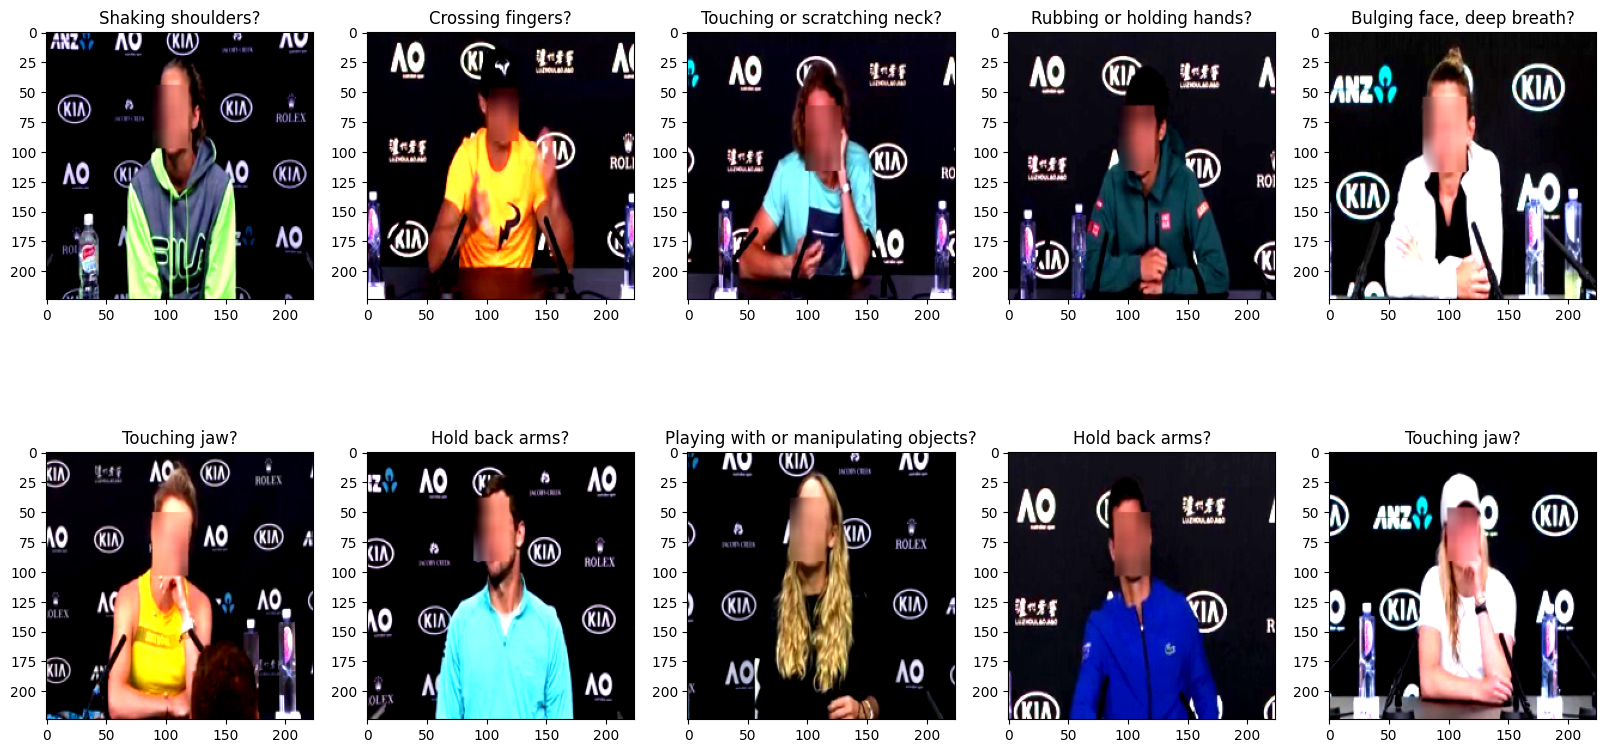

In [43]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

labels = range(32)
id2label = dict(zip(labels, df.Description.to_list()))
label2id = dict(zip(df.Description.to_list(), labels))

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
for i, d in enumerate(data['train']):
    # print(d)
    l = d['labels']
    pv = d['pixel_values']
    print(pv.shape)
    axs[i].imshow((pv.permute(1,2,0) + .7).clip(0,1))
    axs[i].set_title(f"{id2label[l]}?")
    if i >= 9:
        break

In [49]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)
model.to('cuda')

training_args = TrainingArguments(
    output_dir="model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=10,
    # use_cpu=True,
    dataloader_num_workers=16,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
0,1.821100,1.788396,0.547302


TrainOutput(global_step=378, training_loss=2.1808572143473954, metrics={'train_runtime': 202.0302, 'train_samples_per_second': 239.623, 'train_steps_per_second': 1.871, 'total_flos': 3.750380558685831e+18, 'train_loss': 2.1808572143473954, 'epoch': 1.0})

In [51]:
# Next 2 epochs

training_args = TrainingArguments(
    output_dir="model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    warmup_ratio=0.1,
    logging_steps=10,
    # use_cpu=True,
    dataloader_num_workers=16,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
0,1.405900,1.345754,0.620094
1,1.056400,1.189597,0.663224


TrainOutput(global_step=756, training_loss=1.3267230047750724, metrics={'train_runtime': 408.9772, 'train_samples_per_second': 236.742, 'train_steps_per_second': 1.849, 'total_flos': 7.500373553243161e+18, 'train_loss': 1.3267230047750724, 'epoch': 2.0})

## Inference

In [85]:
from transformers import pipeline

classifier = pipeline("image-classification", model='model/checkpoint-756', device='cuda')

In [86]:
data = load_dataset('TornikeO/imigue',)

Actual class  Turtle neck


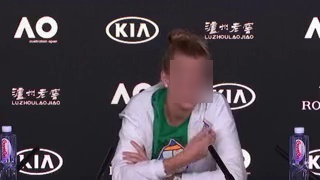

[{'label': 'Illustrative body language', 'score': 0.6816530823707581}, {'label': 'Moving torso', 'score': 0.08216014504432678}, {'label': 'Pressing lips', 'score': 0.02321295440196991}, {'label': 'Shaking shoulders', 'score': 0.02253975346684456}, {'label': 'Playing with or manipulating objects', 'score': 0.021754782646894455}]
Actual class  Touching jaw


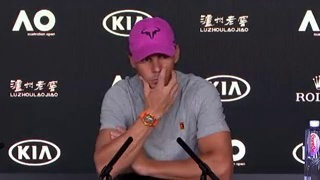

[{'label': 'Touching or scratching facial parts', 'score': 0.5863118767738342}, {'label': 'Touching jaw', 'score': 0.09117323905229568}, {'label': 'Rubbing eyes', 'score': 0.029664304107427597}, {'label': 'Buckle button, pulling shirt collar, adjusting tie', 'score': 0.0185853224247694}, {'label': 'Covering face', 'score': 0.018234217539429665}]
Actual class  Touching jaw


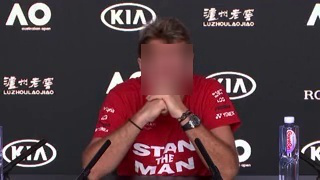

[{'label': 'Touching jaw', 'score': 0.7868590950965881}, {'label': 'Touching or scratching facial parts', 'score': 0.02658710442483425}, {'label': 'Illustrative body language', 'score': 0.018340248614549637}, {'label': 'Rubbing or holding hands', 'score': 0.01530542317777872}, {'label': 'Crossing fingers', 'score': 0.011590149253606796}]
Actual class  Touching jaw


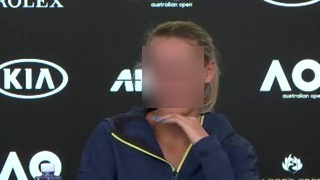

[{'label': 'Touching jaw', 'score': 0.7685324549674988}, {'label': 'Touching or scratching facial parts', 'score': 0.024860002100467682}, {'label': 'Rubbing or holding hands', 'score': 0.01853206194937229}, {'label': 'Illustrative body language', 'score': 0.013958904892206192}, {'label': 'Touching or scratching neck', 'score': 0.012650028802454472}]
Actual class  Touching jaw


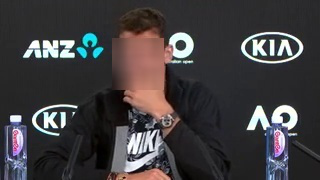

[{'label': 'Touching jaw', 'score': 0.7740399241447449}, {'label': 'Touching or scratching facial parts', 'score': 0.043879784643650055}, {'label': 'Illustrative body language', 'score': 0.02003992162644863}, {'label': 'Rubbing or holding hands', 'score': 0.01147455908358097}, {'label': 'Playing with or manipulating objects', 'score': 0.010782439261674881}]
Actual class  Touching or scratching neck


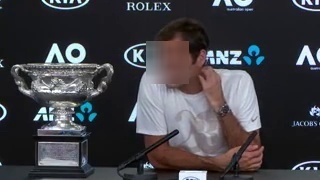

[{'label': 'Touching or scratching neck', 'score': 0.5573203563690186}, {'label': 'Touching or scratching head', 'score': 0.05157320201396942}, {'label': 'Playing with or adjusting hair', 'score': 0.03768997639417648}, {'label': 'Buckle button, pulling shirt collar, adjusting tie', 'score': 0.034221101552248}, {'label': 'Touching or scratching facial parts', 'score': 0.03370280563831329}]
Actual class  Touching or scratching neck


--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 992

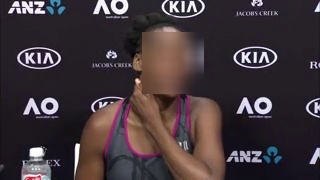

[{'label': 'Touching or scratching neck', 'score': 0.6987375020980835}, {'label': 'Touching or scratching head', 'score': 0.028983455151319504}, {'label': 'Touching or scratching facial parts', 'score': 0.027310747653245926}, {'label': 'Buckle button, pulling shirt collar, adjusting tie', 'score': 0.02719074673950672}, {'label': 'Playing with or adjusting hair', 'score': 0.02175964042544365}]
Actual class  Touching or scratching neck


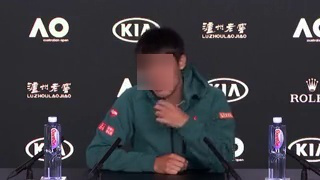

[{'label': 'Touching or scratching neck', 'score': 0.23022259771823883}, {'label': 'Buckle button, pulling shirt collar, adjusting tie', 'score': 0.12528730928897858}, {'label': 'Illustrative body language', 'score': 0.071468785405159}, {'label': 'Playing with or manipulating objects', 'score': 0.06924177706241608}, {'label': 'Folding arms', 'score': 0.06428372859954834}]
Actual class  Playing with or adjusting hair


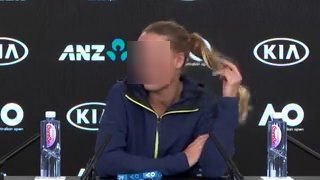

[{'label': 'Touching or scratching head', 'score': 0.21356309950351715}, {'label': 'Illustrative body language', 'score': 0.12182853370904922}, {'label': 'Touching or scratching forehead', 'score': 0.05959555506706238}, {'label': 'Playing with or adjusting hair', 'score': 0.05876074731349945}, {'label': 'Touching or scratching facial parts', 'score': 0.05143514275550842}]
Actual class  Buckle button, pulling shirt collar, adjusting tie


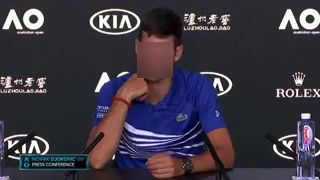

[{'label': 'Touching or scratching facial parts', 'score': 0.44800639152526855}, {'label': 'Touching or scratching neck', 'score': 0.09137625247240067}, {'label': 'Illustrative body language', 'score': 0.050684768706560135}, {'label': 'Touching jaw', 'score': 0.04996902495622635}, {'label': 'Buckle button, pulling shirt collar, adjusting tie', 'score': 0.045365914702415466}]
Actual class  Folding arms


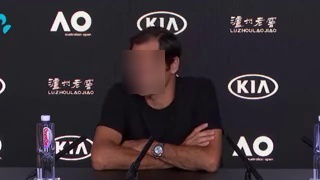

[{'label': 'Folding arms', 'score': 0.5943975448608398}, {'label': 'Shaking shoulders', 'score': 0.09832199662923813}, {'label': 'Pressing lips', 'score': 0.07480192184448242}, {'label': 'Scratching or touching arms', 'score': 0.02974512428045273}, {'label': 'Moving torso', 'score': 0.025287659838795662}]
Actual class  Folding arms


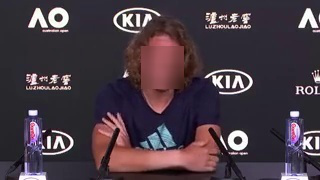

[{'label': 'Folding arms', 'score': 0.3624955713748932}, {'label': 'Illustrative body language', 'score': 0.3242207467556}, {'label': 'Scratching or touching arms', 'score': 0.06155800819396973}, {'label': 'Shaking shoulders', 'score': 0.05236824229359627}, {'label': 'Moving torso', 'score': 0.04245974123477936}]
Actual class  Folding arms


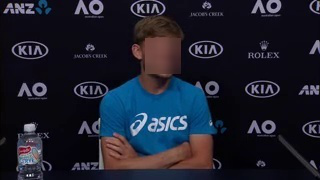

[{'label': 'Folding arms', 'score': 0.6982272267341614}, {'label': 'Shaking shoulders', 'score': 0.038071516901254654}, {'label': 'Pressing lips', 'score': 0.036775700747966766}, {'label': 'Scratching or touching arms', 'score': 0.03474210575222969}, {'label': 'Moving torso', 'score': 0.026231322437524796}]
Actual class  Folding arms


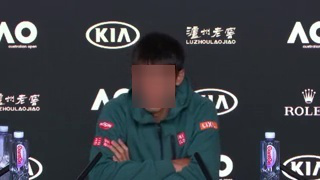

[{'label': 'Folding arms', 'score': 0.7737091779708862}, {'label': 'Shaking shoulders', 'score': 0.02041296660900116}, {'label': 'Scratching or touching arms', 'score': 0.01834559254348278}, {'label': 'Pressing lips', 'score': 0.015208938159048557}, {'label': 'Illustrative body language', 'score': 0.013417853973805904}]
Actual class  Dustoffing clothes


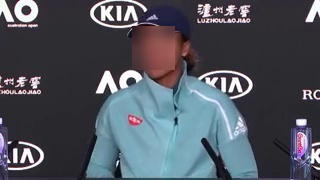

[{'label': 'Moving torso', 'score': 0.35333874821662903}, {'label': 'Pressing lips', 'score': 0.2048254907131195}, {'label': 'Hold back arms', 'score': 0.05383046343922615}, {'label': 'Bulging face, deep breath', 'score': 0.049065519124269485}, {'label': 'Shaking shoulders', 'score': 0.0454769991338253}]
Actual class  Bulging face, deep breath


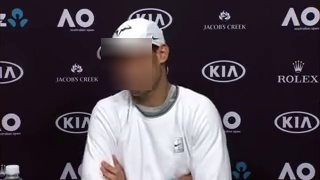

[{'label': 'Shaking shoulders', 'score': 0.6826704740524292}, {'label': 'Pressing lips', 'score': 0.06959354877471924}, {'label': 'Moving torso', 'score': 0.05789954587817192}, {'label': 'Bulging face, deep breath', 'score': 0.05319705978035927}, {'label': 'Illustrative body language', 'score': 0.023891758173704147}]
Actual class  Bulging face, deep breath


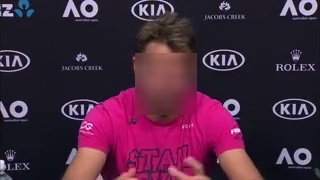

[{'label': 'Illustrative body language', 'score': 0.7633757591247559}, {'label': 'Shaking shoulders', 'score': 0.09089598059654236}, {'label': 'Moving torso', 'score': 0.04971632733941078}, {'label': 'Pressing lips', 'score': 0.0206511989235878}, {'label': 'Bulging face, deep breath', 'score': 0.011648879386484623}]
Actual class  Bulging face, deep breath


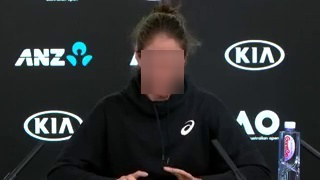

[{'label': 'Illustrative body language', 'score': 0.8720468878746033}, {'label': 'Shaking shoulders', 'score': 0.01979842223227024}, {'label': 'Moving torso', 'score': 0.017313191667199135}, {'label': 'Rubbing or holding hands', 'score': 0.013723436743021011}, {'label': 'Crossing fingers', 'score': 0.011562409810721874}]
Actual class  Moving torso


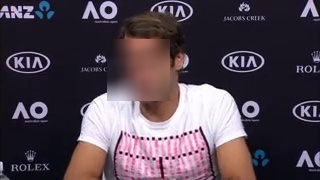

[{'label': 'Illustrative body language', 'score': 0.34279748797416687}, {'label': 'Shaking shoulders', 'score': 0.30784764885902405}, {'label': 'Pressing lips', 'score': 0.15308016538619995}, {'label': 'Moving torso', 'score': 0.06952861696481705}, {'label': 'Bulging face, deep breath', 'score': 0.03890062868595123}]
Actual class  Moving torso


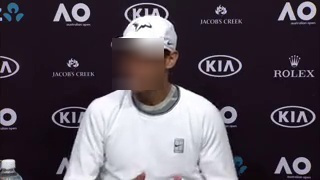

[{'label': 'Pressing lips', 'score': 0.3880845010280609}, {'label': 'Shaking shoulders', 'score': 0.2431630939245224}, {'label': 'Moving torso', 'score': 0.1293714940547943}, {'label': 'Bulging face, deep breath', 'score': 0.06811223924160004}, {'label': 'Illustrative body language', 'score': 0.045798953622579575}]


In [88]:
from IPython.display import display
for i in range(0, 10_000, 500):
    sample = data['train'][i]
    sample_img = data['train'][i]['image']
    sample_class = data['train'][i]['class'] - 1 # Don't forget this!
    sample_class = id2label[sample_class]
    print('Actual class ',  sample_class)
    display(sample_img)
    pred = classifier(sample_img)
    # Predictions are pretty crap!
    print(pred)